In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import json

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import argparse

def process_logs(prefix, workload_path):
    warmup = 0
    if prefix[-1] != "_":
        prefix += "_"

    # Read in consumer log. Sort according to sample id.
    with open(prefix+"consumer.txt", "r") as f:
        cons_lines = f.readlines()[warmup:]

    cons_lines_parse = []
    for l in cons_lines:
        # Format: time, id, pred
        l = l.split(",")
        cons_lines_parse.append((int(l[1]), float(l[0]), int(l[2])))

    cons_lines = sorted(cons_lines_parse)

    with open(prefix+"producer.txt", "r") as f:
        # NOTE: Assume sorted according to id
        prod_lines = f.readlines()[warmup:]

    history = np.load(workload_path)
    #history = [1000] * 5
    
    with open("tiny.csv", "r") as f:
        lines = f.readlines()
        labels = [int(l.split(",")[1]) for l in lines]

    print("Qs in history:", np.sum(history), "Qs in consumer:", len(cons_lines), "Qs in producer:", len(prod_lines))

    # Print.
    lats = []
    p50_lat_by_interval = []
    p95_lat_by_interval = []
    p99_lat_by_interval = []
    acc_by_interval = []
    line_ctr = 0
    corr = 0
    incorr = 0

    diff_count = 0
    for qps in history:
        qps = int(qps)
        #print("QPS", qps, "="*10)

        if qps == 0:
            continue

        q_lats = []
        q_corr = 0
        q_incorr = 0
        q_ids = []
        q_enter = []
        q_leave = []

        for q in range(qps):
            if line_ctr >= len(cons_lines):
                print("TOO FEW LiNES IN CONSUMER FILE", "="*10)
                break

            if line_ctr >= len(prod_lines):
                print("TOO FEW LiNES IN PRODUCER FILE", "="*10)
                break

            # Get sample from producer log.
            p = prod_lines[line_ctr]
            p = p.split(",")
            sample_id = int(p[1])
            assert sample_id >= warmup # Warmup is legacy.

            q_ids.append(sample_id)
            p_time = float(p[0])

            # Get sample from consumer log.
            c = cons_lines[sample_id]
            # assert c[0] == sample_id # TODO: Comment back in
            c_time = c[1]
            pred = c[2]

            # Get sample correctness.
            sample_id = c[0]
            label = labels[sample_id%len(labels)]
            if pred == label:
                corr += 1
                q_corr += 1
            else:
                incorr += 1
                q_incorr += 1

            # Get sample latency.
            lats.append(c_time-p_time)
            q_lats.append(c_time-p_time)
            q_enter.append(p_time)
            q_leave.append(c_time)

            line_ctr += 1

        if len(q_lats) > 0:
            acc = q_corr/(q_incorr+q_corr)
            acc_by_interval.append(acc)
            p50_lat_by_interval.append(np.percentile(q_lats, 50))
            p95_lat_by_interval.append(np.percentile(q_lats, 95))
            p99_lat_by_interval.append(np.percentile(q_lats, 99))
            max_q = np.argmax(q_lats)
            #print(f"accuracy: {acc}, max lat: {q_lats[max_q]}, p50 lat: {np.percentile(q_lats, 50)}, "
             #     f"p95 lat: {np.percentile(q_lats, 50)}, p99 lat: {np.percentile(q_lats, 99)}")
        else:
            acc_by_interval.append(-1)
            p50_lat_by_interval.append(-1)
            p95_lat_by_interval.append(-1)
            p99_lat_by_interval.append(-1)

        if line_ctr >= len(cons_lines) or line_ctr >= len(prod_lines):
            break

    print("\nAcc:")
    print(corr / (incorr + corr))

    # get latecies.
    print("\nLatencies:")
    lats = sorted(lats)
    print("p99:   ", lats[int(len(lats) * 0.99)])
    print("p95:   ", lats[int(len(lats) * 0.95)])
    print("p90:   ", lats[int(len(lats) * 0.90)])
    print("p50:   ", lats[int(len(lats) * 0.50)])
    return history, acc_by_interval, p50_lat_by_interval, p95_lat_by_interval, p99_lat_by_interval


def smooth_accuracy_curve(acc, k=2):
    new_acc = np.zeros(len(acc))
    for i in range(len(acc)):
        start = max(i-k, 0)
        end = min(i+k, len(acc))
        new_acc[i] = np.mean(acc[start: end])
    return new_acc

In [57]:
# Old way of computing acc.
prefix = "sf95_n1_qpsmul1.0_maxbs0_ql0_p0.1"
prefix_bs = "sf95_n4_qpsmul1.0_maxbs0_ql0_p0.1_baseline"
prefix_bs2 = "sf95_n3_qpsmul1.0_maxbs0_ql0_p0.1_baseline_ms"
prefix_bs3 = "max_-1_1000_2_"
workload_path = "twitter_trace_spiky2.npy"
n = 1
n_bs = 4
n_bs2 = 3
smooth = True

history, acc_by_interval, p50_lat_by_interval, p95_lat_by_interval, p99_lat_by_interval = process_logs(prefix, workload_path)
if smooth:
    acc_by_interval[0:230] = smooth_accuracy_curve(acc_by_interval[0:230], k=7)
    acc_by_interval[230:] = smooth_accuracy_curve(acc_by_interval[230:], k=6)
    p50_lat_by_interval[0:10] = p50_lat_by_interval[10:20]  #warm up time
    p95_lat_by_interval[0:10] = p95_lat_by_interval[10:20]
    #acc_by_interval[50:150] = smooth_accuracy_curve(acc_by_interval[50:150], k=3)
    #acc_by_interval[150:250] = smooth_accuracy_curve(acc_by_interval[150:250], k=2)
if prefix_bs is not None:
    _, acc_by_interval_bs, p50_lat_by_interval_bs, p95_lat_by_interval_bs, p99_lat_by_interval_bs = process_logs(prefix_bs, workload_path)
    if smooth:
        acc_by_interval_bs[0:230] = smooth_accuracy_curve(acc_by_interval_bs[0:230], k=6)
        acc_by_interval_bs[230:] = smooth_accuracy_curve(acc_by_interval_bs[230:], k=6)
        #acc_by_interval_bs[50:150] = smooth_accuracy_curve(acc_by_interval_bs[50:150], k=3)
        #acc_by_interval_bs[150:250] = smooth_accuracy_curve(acc_by_interval_bs[150:250], k=2)
if prefix_bs2 is not None:
    _, acc_by_interval_bs2, p50_lat_by_interval_bs2, p95_lat_by_interval_bs2, p99_lat_by_interval_bs2 = process_logs(prefix_bs2, workload_path)
    if smooth:
        acc_by_interval_bs2[0:230] = smooth_accuracy_curve(acc_by_interval_bs2[0:230], k=5)
        acc_by_interval_bs2[230:] = smooth_accuracy_curve(acc_by_interval_bs2[230:], k=5)
        #acc_by_interval_bs[50:150] = smooth_accuracy_curve(acc_by_interval_bs[50:150], k=3)
        #acc_by_interval_bs[150:250] = smooth_accuracy_curve(acc_by_interval_bs[150:250], k=2)
if prefix_bs3 is not None:
    _, acc_by_interval_bs3, p50_lat_by_interval_bs3, p95_lat_by_interval_bs3, p99_lat_by_interval_bs3 = process_logs(prefix_bs3, workload_path)
    if smooth:
        acc_by_interval_bs3[0:230] = smooth_accuracy_curve(acc_by_interval_bs3[0:230], k=5)
        acc_by_interval_bs3[230:] = smooth_accuracy_curve(acc_by_interval_bs3[230:], k=5)

# Ours second
_, _, _, p95_lat_by_interval_ours2, _ = process_logs("ours2", workload_path)


# To make plot more legible: Take Accuracy over 16000 window and add noise, then smooth.
noise_stddev = 0.003
window_size = 7
window = np.ones(window_size) / window_size
qps_history = np.array(history)
qps_history = np.append(qps_history, [500]*(window_size-1))

acc_ours = np.zeros(qps_history.shape[0])
acc_ours[qps_history <= 6000] = 0.84
acc_ours[qps_history <= 4000] = 0.84775
acc_ours[qps_history <= 600] = 0.853
acc_ours += np.random.normal(0, noise_stddev, size=acc_ours.shape)
acc_ours = np.convolve(acc_ours, window, 'valid')

acc_ours2 = np.zeros(qps_history.shape[0])
acc_ours2[qps_history <= 6000] = 0.847125
acc_ours2[qps_history <= 4000] = 0.849063
acc_ours2[qps_history <= 600] = 0.853
acc_ours2 += np.random.normal(0, noise_stddev, size=acc_ours2.shape)
acc_ours2 = np.convolve(acc_ours2, window, 'valid')

acc_ms = np.zeros(qps_history.shape[0])
acc_ms[qps_history <= 6000] = 0.824
acc_ms[qps_history <= 4000 ] = 0.8365
acc_ms[qps_history <= 600] = 0.848625
acc_ms += np.random.normal(0, noise_stddev, size=acc_ms.shape)
acc_ms = np.convolve(acc_ms, window, 'valid')

acc_static = np.zeros(qps_history.shape[0])
acc_static[qps_history <= 6000] = 0.848625
acc_static += np.random.normal(0, noise_stddev, size=acc_static.shape)
acc_static = np.convolve(acc_static, window, 'valid')

acc_cct = np.zeros(qps_history.shape[0])
acc_cct[qps_history <= 6000] = 0.848625
acc_cct += np.random.normal(0, noise_stddev, size=acc_cct.shape)
acc_cct = np.convolve(acc_cct, window, 'valid')

print(acc_ours.shape, acc_cct.shape)

Qs in history: 384970.0 Qs in consumer: 384400 Qs in producer: 384400
TOO FEW LiNES IN CONSUMER FILE ==========

Acc:
0.8445889698231009

Latencies:
p99:    0.2396233081817627
p95:    0.18559026718139648
p90:    0.16259241104125977
p50:    0.1058053970336914
Qs in history: 384970.0 Qs in consumer: 384400 Qs in producer: 384400
TOO FEW LiNES IN CONSUMER FILE ==========

Acc:
0.8486316337148804

Latencies:
p99:    2.9344801902770996
p95:    2.129612922668457
p90:    1.6110973358154297
p50:    0.07163405418395996
Qs in history: 384970.0 Qs in consumer: 384400 Qs in producer: 384400
TOO FEW LiNES IN CONSUMER FILE ==========

Acc:
0.8363293444328824

Latencies:
p99:    0.19131851196289062
p95:    0.15749526023864746
p90:    0.13771510124206543
p50:    0.0712578296661377
Qs in history: 384970.0 Qs in consumer: 384400 Qs in producer: 384400
TOO FEW LiNES IN CONSUMER FILE ==========

Acc:
0.8486316337148804

Latencies:
p99:    1.555673360824585
p95:    1.1009230613708496
p90:    0.826300621032

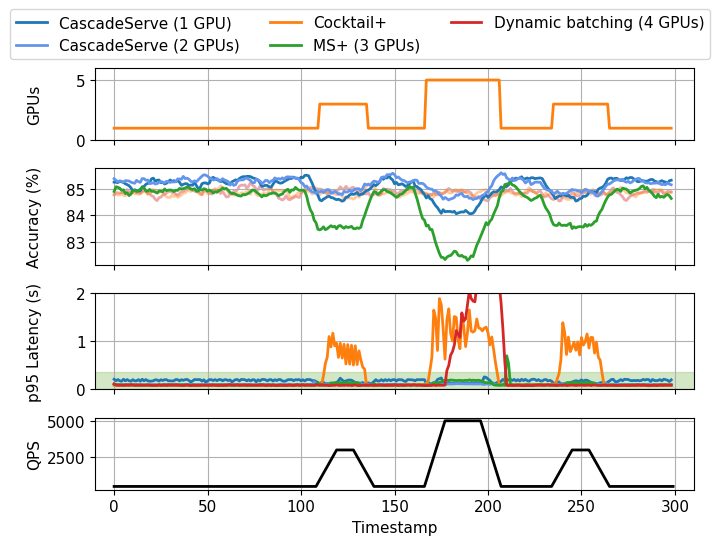

In [71]:
font_size = 11
second_ours_color = "cornflowerblue"
alpha_irrelevant = 0.4

# Set global font sizes for all plots
plt.rcParams.update({'font.size': font_size})

# Create a figure with custom heights for different rows using gridspec_kw
fig, ax = plt.subplots(4, figsize=(7, 5), gridspec_kw={'height_ratios': [1.5, 2, 2, 1.5]})

# Define x values.
bs_len = len(acc_by_interval_bs)
x_bs = np.arange(bs_len)
bs_len2 = len(acc_by_interval_bs2)
x_bs2 = np.arange(bs_len2)
bs_len3 = len(acc_by_interval_bs3)
x_bs3 = np.arange(bs_len3)
x = np.arange(len(acc_by_interval))
plot_len = 300

systems = ["CascadeServe (1 GPU)", "CascadeServe (2 GPUs)", "Cocktail+", "MS+ (3 GPUs)", "Dynamic batching (4 GPUs)"]

# Plot the number of GPUs.
ours_gpus = np.ones(len(acc_by_interval)) * 1
ours_gpus2 = np.ones(len(acc_by_interval)) * 2
# ax[0].plot(x, ours_gpus, linewidth=2, zorder=1, alpha=alpha_irrelevant)
# ax[0].plot(x, ours_gpus2, linewidth=2, zorder=1, alpha=alpha_irrelevant, color=second_ours_color)

ax[0].plot([], [])

cocktail_gpus = np.ones(bs_len3)
cocktail_gpus[110:136] = 3
cocktail_gpus[167:207] = 5
cocktail_gpus[235:265] = 3
ax[0].plot(x_bs3, cocktail_gpus, linewidth=2, zorder=3)
    
# ms_gpus = np.ones(bs_len2) * n_bs2
# ax[0].plot(x_bs2, ms_gpus, linewidth=2, zorder=1, alpha=alpha_irrelevant)

# n_gpu_bs = np.ones(bs_len) * n_bs
# ax[0].plot(x_bs, n_gpu_bs, linewidth=2, zorder=1, alpha=alpha_irrelevant)
ax[0].set_ylim([0,6])

# Plot latency.
rect = mpatches.Rectangle((-100, 0), 500, 0.35, color='#93c572', alpha=0.4)
ax[2].add_patch(rect)

p95_lat_by_interval[0:5] = p95_lat_by_interval[5:10]
lats = [p95_lat_by_interval, p95_lat_by_interval_ours2, p95_lat_by_interval_bs3, p95_lat_by_interval_bs2, p95_lat_by_interval_bs]
ax[2].plot(x, lats[0], label=systems[0], linewidth=2)
ax[2].plot(x, lats[1], label=systems[1], linewidth=2, color=second_ours_color)    
ax[2].plot(x, lats[2], label=systems[2], linewidth=2)
ax[2].plot(x, lats[3], label=systems[3], linewidth=2)
ax[2].plot(x, lats[4], label=systems[4], linewidth=2)
ax[2].set_ylim([0,2])

# Plot the accuracy.
accs = [acc_ours, acc_ours2, acc_cct, acc_ms, acc_static]
accs = [np.array(a[:299])*100 for a in accs]
# for a in accs:
#     ax[1].plot(x, a, linewidth=2)

ax[1].plot(x, accs[0], linewidth=2, zorder=3)
ax[1].plot(x, accs[1], linewidth=2, zorder=3, color=second_ours_color)
ax[1].plot(x, accs[2], linewidth=2, zorder=2, alpha=alpha_irrelevant)
ax[1].plot(x, accs[3], linewidth=2, zorder=4)
ax[1].plot(x, accs[4], linewidth=2, zorder=1, alpha=alpha_irrelevant)

# Plot the QPS.
ax[3].plot(np.arange(len(history)), history, color="black", linewidth=2)
# ax[3].set_ylimit([0, 5000])

# Style subplots.
labels = ["GPUs", "Accuracy (%)", "p95 Latency (s)", "QPS"]
for i, label in enumerate(labels):
    ax[i].grid()
    ax[i].set_ylabel(label)
    ax[i].set_xlim([-10, plot_len+10])

    if i == 3:
        ax[i].set_xlabel("Timestamp")
    else:
        ax[i].set_xticklabels([])

# Align y-axis labels
fig.align_ylabels(ax[:])

# Legend.
legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, fontsize=font_size)
plt.tight_layout()

# Show and save.
plt.savefig("twitter_adapt.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


# Draw 

In [77]:
def compute_lat(prefix="ours_logs_", smooth=5):
    qps_history = np.array([1]*100+[3]*100+[1]*200+[9]*100+[11]*70)

    with open(prefix + "consumer.txt", "r") as f:
        cons_lines = f.readlines()
    
    with open(prefix + "producer.txt", "r") as f:
        prod_lines = f.readlines()
    print(len(cons_lines), len(prod_lines), np.sum(qps_history))
    lats = []
    p50_lat = []
    p95_lat = []
    
    line_ctr = 0
    s_count = 0
    curr_lat = []
    for qps in qps_history:
        qps = int(qps)
        for q in range(qps):
            if line_ctr >= len(cons_lines):
                curr_lat.append(0)
                lats.append(0)
                continue
            c = cons_lines[line_ctr]
            p = prod_lines[line_ctr]
            c = float(c.split(",")[0])
            p = float(p.split(",")[0])
            line_ctr += 1
            curr_lat.append(c-p)
            lats.append(c-p)
        s_count += 1
        if s_count % smooth == 0:
            if len(curr_lat) == 0:
                p50_l = 0
                p95_l = 0
            else:
                p50_l = np.percentile(curr_lat, 50)
                p95_l = np.percentile(curr_lat, 95)
            p95_lat.extend([p95_l] * smooth)
            p50_lat.extend([p50_l] * smooth)
            s_count = 0
            curr_lat = []
    
    # get latecies.
    print("\nLatencies:")
    lats = sorted(lats)
    print("p99:   ", lats[int(len(lats)*0.99)]) 
    print("p95:   ", lats[int(len(lats)*0.95)])
    print("p90:   ", lats[int(len(lats)*0.90)])
    return p50_lat, p95_lat

def get_accuracy(workload_path, model, m=0, std=0.01):
    history = np.array([1]*100+[3]*100+[1]*200+[9]*100+[11]*70)
    
    acc = np.zeros(len(history))
    print(len(acc))
    for i in range(len(history)):
        qps = int(history[i])
        noise = np.random.normal(m, std)
        if model == "ours":
            if qps == 1:
                acc[i] = 0.67 + noise
            elif qps == 3:
                acc[i] = 0.65 + noise
            elif qps >= 8:
                acc[i] = 0.63 + noise
        elif model == "ms":
            if qps == 1:
                acc[i] = 0.67 + noise
            elif qps == 3:
                acc[i] = 0.62 + noise
            elif qps >= 8:
                acc[i] = 0.53 + noise
        elif model == "ours2":
            if qps <= 3:
                acc[i] = 0.67 + noise
            elif qps >= 8:
                acc[i] = 0.63 + noise

        else: 
            acc[i] = 0.67 + noise
    
    acc = smooth_accuracy_curve(acc, k=4)
    return acc


2600 2600 2270

Latencies:
p99:    8.424442529678345
p95:    7.40583872795105
p90:    6.25527024269104
1721 2050 2270

Latencies:
p99:    137.09315252304077
p95:    123.8450219631195
p90:    108.37072205543518
2600 2600 2270

Latencies:
p99:    1.960235595703125
p95:    1.8525395393371582
p90:    1.8104510307312012
1080 2050 2270

Latencies:
p99:    190.31140398979187
p95:    155.55956768989563
p90:    113.23625755310059
2270 2270 2270

Latencies:
p99:    2.123007297515869
p95:    1.428145408630371
p90:    1.209200143814087
570
570
570
570
570
570 570


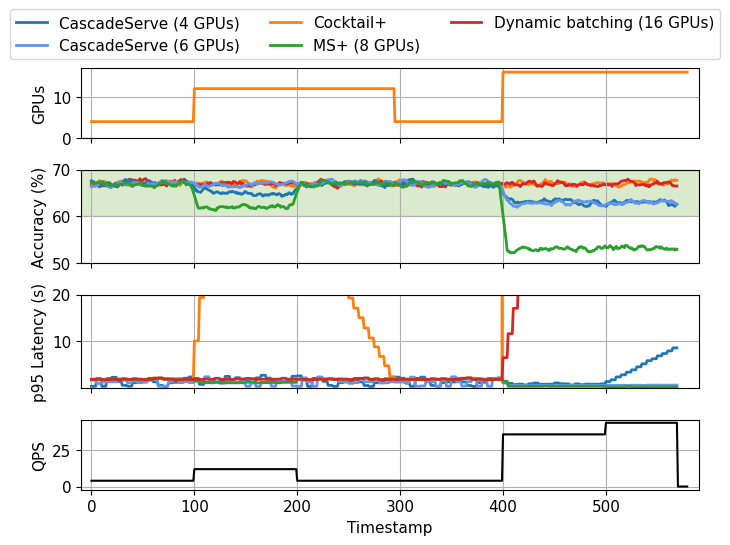

In [91]:
font_size = 11

# Set global font sizes for all plots
plt.rcParams.update({'font.size': font_size})


prefix = "run_ours_new3_"
prefix_bs = "static_logs_new_"
prefix_bs2 = "ms_logs_new3_"
prefix_bs3 = "cocktail_logs_new_"

n = 4
n_bs = 16
n_bs2 = 8
smooth = 5
full_history = np.array([1]*100+[3]*100+[1]*200+[9]*100+[11]*70+[0]*10) * 4
non_zero_history = np.array([1]*100+[3]*100+[1]*200+[9]*100+[11]*70)
plot_len = len(full_history)


p50_lat_by_interval, p95_lat_by_interval = compute_lat(prefix, smooth)

p50_lat_by_interval[0:10] = p50_lat_by_interval[10:20]  #warm up time
p95_lat_by_interval[0:10] = p95_lat_by_interval[10:20]
    
if prefix_bs is not None:
    p50_lat_by_interval_bs, p95_lat_by_interval_bs = compute_lat(prefix_bs, smooth)
    p95_lat_by_interval_bs = np.asarray(p95_lat_by_interval_bs)
    p95_lat_by_interval_bs[450:] = 1000
    
if prefix_bs2 is not None:
    p50_lat_by_interval_bs2, p95_lat_by_interval_bs2 = compute_lat(prefix_bs2, smooth)
    
if prefix_bs3 is not None:
    p50_lat_by_interval_bs3, p95_lat_by_interval_bs3 = compute_lat(prefix_bs3, smooth)
    p95_lat_by_interval_bs3 = np.asarray(p95_lat_by_interval_bs3)
    p95_lat_by_interval_bs3[400:] = 1000


_, p95_ours2 = compute_lat("llama_n3_", smooth)

# The p95_ours2 looks exactly like the first one (makes sense but looks shit on the plot)
p95_ours2 = np.array(p95_ours2)
reshaped_arr = p95_ours2[:400].reshape(-1, 5)
np.random.shuffle(reshaped_arr)
permuted_arr = reshaped_arr.flatten()
p95_ours2[:400] = permuted_arr



acc_by_interval = get_accuracy(workload_path, "ours")
acc_by_interval_bs = get_accuracy(workload_path, "static")
acc_by_interval_bs2 = get_accuracy(workload_path, "ms")
acc_by_interval_bs3 = get_accuracy(workload_path, "cocktail")
acc_by_interval_ours2 = get_accuracy(workload_path, "ours2")



bs_len = len(p50_lat_by_interval_bs)
x_bs = np.arange(bs_len)
print(bs_len, len(x_bs))
if prefix_bs2 is not None:
    bs_len2 = len(p50_lat_by_interval_bs2)
    x_bs2 = np.arange(bs_len2)
if prefix_bs3 is not None:
    bs_len3 = len(p50_lat_by_interval_bs3)
    x_bs3 = np.arange(bs_len3)

# Plot number of GPUs.
x = np.arange(plot_len)
fig, ax = plt.subplots(4, figsize=(7, 5), gridspec_kw={'height_ratios': [1.5, 2, 2, 1.5]})
ax[0].set_ylim([0, 17])

# n_gpu = np.ones(plot_len) * n
# ax[0].plot(x, n_gpu, linewidth=2, label="CascadeServe")

# GPUs Cocktail+
n_gpu_bs3 = np.ones(plot_len) * 4
n_gpu_bs3[100:295] = 12
n_gpu_bs3[400:] = 16
ax[0].plot([], [], linewidth=2)
ax[0].plot(x, n_gpu_bs3, linewidth=2)

# n_gpu_bs2 = np.ones(plot_len) * n_bs2
# ax[0].plot(x, n_gpu_bs2, linewidth=2, label="MS+")

# n_gpu_bs = np.ones(plot_len) * n_bs
# ax[0].plot(x, n_gpu_bs, linewidth=2, label="Dynamic batching")


# Plot accuracies.
rect = mpatches.Rectangle((-10, 60), plot_len+20, 10, color='#93c572', alpha=0.35)
ax[1].add_patch(rect)

xs = [np.arange(len(p50_lat_by_interval)), x_bs, x_bs2, x_bs3]
accs = [acc_by_interval, acc_by_interval_ours2, acc_by_interval_bs3[:bs_len3], acc_by_interval_bs2[:bs_len2], acc_by_interval_bs[:bs_len]]
accs = [np.array(a)*100 for a in accs]

ax[1].plot(xs[0], accs[0], linewidth=2, zorder=3)
ax[1].plot(xs[0], accs[1], linewidth=2, zorder=3, color=second_ours_color)
ax[1].plot(xs[1], accs[2], linewidth=2, zorder=1)
ax[1].plot(xs[2], accs[3], linewidth=2, zorder=3)
ax[1].plot(xs[3], accs[4], linewidth=2, zorder=1)


ax[1].set_ylim([50, 70])

# ax[1].plot(x, acc_by_interval, color="tomato", alpha=0.6)
# ax[1].plot(x_bs, acc_by_interval_bs[:bs_len], color="darkblue", alpha=0.6)
# ax[1].plot(x_bs2, acc_by_interval_bs2[:bs_len2], color="olive", alpha=0.7)
# ax[1].plot(x_bs3, acc_by_interval_bs3[:bs_len3], color="gold", alpha=0.8)


# Plot latencies.
lats = [p95_lat_by_interval, p95_ours2, p95_lat_by_interval_bs3, p95_lat_by_interval_bs2, p95_lat_by_interval_bs]

ax[2].plot(x_bs, lats[0], linewidth=2, label="CascadeServe (4 GPUs)")
ax[2].plot(x_bs, lats[1], linewidth=2, color=second_ours_color, label="CascadeServe (6 GPUs)")
ax[2].plot(x_bs, lats[2], linewidth=2, label="Cocktail+")
ax[2].plot(x_bs, lats[3], linewidth=2, label="MS+ (8 GPUs)")
ax[2].plot(x_bs, lats[4], linewidth=2, label="Dynamic batching (16 GPUs)")

ax[2].set_ylim([0.05, 20])


# Plot QPS.
ax[3].plot(np.arange(len(full_history)), full_history, color="black")


# Style subplots.
labels = ["GPUs", "Accuracy (%)", "p95 Latency (s)", "QPS"]
for i, label in enumerate(labels):
    ax[i].grid()
    ax[i].set_ylabel(label)
    ax[i].set_xlim([-10, plot_len+10])

    if i == 3:
        ax[i].set_xlabel("Timestamp")
    else:
        ax[i].set_xticklabels([])

# Legend.
legend = fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.tight_layout()

# Show and save.
plt.savefig("llama_adapt.pdf", bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


In [138]:
history[400]

40.0

In [154]:
np.random.normal(0, 0.05)

-0.05642358423610621